In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import soundfile

import warnings
warnings.filterwarnings("ignore")

from composition.common import (
    sinusoid, sweeping_sinusoid, line_segment, constant, triangle, square, adsr,
    to_db_loudness, generate_audio, autotune, SECOND, get_t
)

# Required for restoring loudness statistics, even though it is not used in this notebook.
from utils import QuantileTransformer

plt.rcParams['figure.figsize'] = (15, 5)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
def show(pitch, loudness):
    steps = len(loudness)
    dur = steps / SECOND
    t = np.linspace(0, dur, steps)
    
    fig,ax = plt.subplots()
    ax2=ax.twinx()
    
    ax.plot(t, loudness, color='red')
    ax2.plot(t, pitch, color='blue')

In [3]:
def make_part(instrument, pitch, loudness, db_offset):
    #we can save and restore all parameters for generating score later
    return {
        'instrument': instrument,
        'pitch': pitch,
        'loudness': loudness,
        'db_offset': db_offset,
    }

In [4]:
def pad(xs, duration):
    start = constant(duration, xs[0])
    end = constant(duration, xs[-1])
    
    return np.concatenate([start, xs, end])

- Violin 55-103
- Viola 48-91
- Cello 36-76
- Flute 60-96
- Flute2 55-91

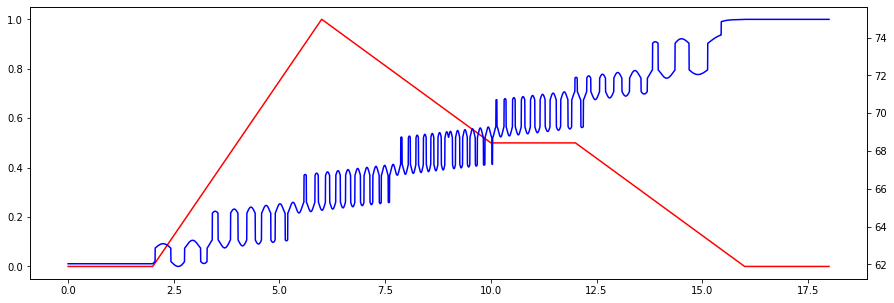

In [5]:
duration = 14
padding = constant(2, 1)
phi = (np.sqrt(5) + 1) / 2

# loudness = triangle(duration, 2, 0.25)
# loudness += line_segment(duration, 0, 2)
loudness = adsr(4, 4, 2, 4, 1, 0.5)
loudness = np.concatenate([padding * 0, loudness, padding * 0])

pitch = line_segment(duration, 62, 74)
# pitch = sinusoid(duration, 0.05, 72, 12)
modulation = np.concatenate([
    sweeping_sinusoid(duration / 2, 1, 6, 0.1),
    sweeping_sinusoid(duration / 2, 6, 0.1, 0.1)
])
pitch += modulation
pitch = autotune(pitch, 0.7, 'melodic_minor')
pitch = np.concatenate([padding * pitch[0], pitch, padding * pitch[-1]])

show(pitch, loudness)

In [6]:
part = make_part('violin', pitch, loudness, -16)
audio = generate_audio(**part)
Audio(audio, rate=16000)

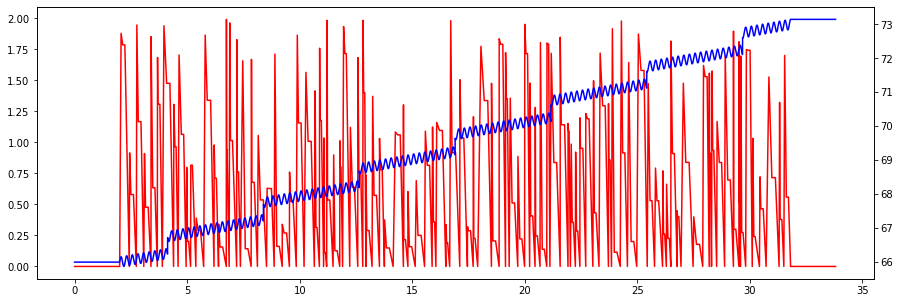

In [7]:
envelopes = []
for i in range(100):
    duration = np.random.uniform(0.1, 0.2)
    bp = np.random.uniform(0, duration, 4)
    pv = np.random.uniform(0.1, 2, 2)
    bp.sort()
    pv.sort()
    envelopes.append(adsr(bp[0], bp[1], bp[2], bp[3], pv[1], pv[0]))
    # envelopes.append(triangle(duration, 1/duration, highest=np.random.uniform(0.1, 2)))

loudness = np.concatenate(envelopes)
duration = len(loudness) / SECOND

pitch = line_segment(duration, 66, 73)
pitch = autotune(pitch, 0.5)
pitch += sinusoid(duration, 4, 0, 0.15)

loudness = pad(loudness, 2)
pitch = pad(pitch, 2)
show(pitch, loudness)

In [9]:
part = make_part('flute', pitch, loudness, -2)
audio = generate_audio(**part)
Audio(audio, rate=16000)